In [482]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 105)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
sns.set()

In [483]:
# setting the number of cross validations used in the Model part 
nr_cv = 5

# switch for using log values for SalePrice and features     
use_logvals = 1    
# target used for correlation 
# target = 'NZ_median_price'
target = 'HPI'
    
# only columns with correlation above this threshold value  
# are used for the ML Regressors in Part 3
min_val_corr = 0.3   
    
# switch for dropping columns that are similar to others already used and show a high correlation to these     
drop_similar = 1

In [484]:
def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

In [485]:
def print_cols_large_corr(df, nr_c, targ) :
    corr = df.corr()
    corr_abs = corr.abs()
    print (corr_abs.nlargest(nr_c, targ)[targ])

In [486]:
def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

In [487]:
#load data
data = pd.read_csv('Data.csv')

In [488]:
data.shape

(279, 19)

In [489]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   279 non-null    int64  
 1   OCR                    279 non-null    float64
 2   NZ_median_price        279 non-null    int64  
 3   Auckland_median_price  279 non-null    int64  
 4   CPI                    279 non-null    float64
 5   Inflation              279 non-null    float64
 6   Population             279 non-null    int64  
 7   GDP_Growth_NZ          279 non-null    float64
 8   BC_Auckland            279 non-null    int64  
 9   BC_NZ                  279 non-null    int64  
 10  Marriage_rate          279 non-null    float64
 11  Divorce_rate           279 non-null    float64
 12  Birth_rate             279 non-null    float64
 13  Earnings               279 non-null    float64
 14  Exchange_rate          279 non-null    float64
 15  NZX   

In [490]:
data.head()

,Date,OCR,NZ_median_price,Auckland_median_price,CPI,Inflation,Population,GDP_Growth_NZ,BC_Auckland,BC_NZ,Marriage_rate,Divorce_rate,Birth_rate,Earnings,Exchange_rate,NZX,GDP,Election,HPI
0,1,0.0525,170000,230000,687.407882,0.015,3853500,0.054,748,1527,0.1549,0.122,0.0198,542.41,0.513300,1830.84,37596,0,764
1,2,0.0525,171000,245000,687.407882,0.015,3853500,0.054,582,1620,0.1549,0.122,0.0198,542.41,0.491060,1830.84,37596,0,771
2,3,0.0575,175000,240000,687.407882,0.015,3853500,0.054,793,2062,0.1549,0.122,0.0198,542.41,0.491348,1830.84,37596,0,768
3,4,0.0600,177000,245000,692.157986,0.020,3856800,0.060,526,1405,0.1549,0.122,0.0198,540.12,0.496174,1830.84,37020,0,769
4,5,0.0650,172000,240000,692.157986,0.020,3856800,0.060,873,2103,0.1549,0.122,0.0198,540.12,0.471168,1830.84,37020,0,764


In [491]:
data.describe()

,Date,OCR,NZ_median_price,Auckland_median_price,CPI,Inflation,Population,GDP_Growth_NZ,BC_Auckland,BC_NZ,Marriage_rate,Divorce_rate,Birth_rate,Earnings,Exchange_rate,NZX,GDP,Election,HPI
count,279.000000,279.000000,279.000000,2.790000e+02,279.000000,279.000000,2.790000e+02,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000
mean,140.000000,0.038127,415962.749104,5.912837e+05,913.487204,0.024561,4.459549e+06,0.028806,814.777778,2288.197133,0.122994,0.099978,0.019331,846.035269,0.671565,5432.043656,52682.161290,0.250896,1932.795699
std,80.684571,0.023288,188388.718584,2.754902e+05,130.991787,0.016162,3.974933e+05,0.017694,456.429040,874.282090,0.021905,0.019315,0.001734,201.898349,0.111425,3446.009479,9357.013833,0.434308,901.586686
min,1.000000,0.002500,170000.000000,2.300000e+05,687.407882,0.000835,3.853500e+06,-0.018000,187.000000,812.000000,0.077300,0.062000,0.016100,540.120000,0.399671,1731.980000,37020.000000,0.000000,745.000000
25%,70.500000,0.020000,294500.000000,3.805000e+05,798.696029,0.014787,4.153500e+06,0.023000,465.000000,1627.500000,0.109000,0.084000,0.018100,656.540000,0.630012,3003.500000,46477.000000,0.000000,1404.000000
50%,140.000000,0.030000,358000.000000,4.770000e+05,944.535073,0.019024,4.388000e+06,0.032000,720.000000,2174.000000,0.125100,0.099000,0.019700,838.060000,0.691336,3863.710000,50592.000000,0.000000,1625.000000
75%,209.500000,0.057500,527500.000000,8.463000e+05,1000.000000,0.031551,4.805200e+06,0.039000,1075.500000,2757.000000,0.141700,0.119000,0.020900,983.360000,0.735855,7515.170000,59895.000000,0.500000,2606.500000
max,279.000000,0.082500,925000.000000,1.300000e+06,1218.000000,0.073013,5.140800e+06,0.060000,2313.000000,5303.000000,0.154900,0.128000,0.021900,1300.730000,0.868755,13275.760000,72699.000000,1.000000,4276.000000


In [492]:
df_train = data

In [493]:
df_train.head()

,Date,OCR,NZ_median_price,Auckland_median_price,CPI,Inflation,Population,GDP_Growth_NZ,BC_Auckland,BC_NZ,Marriage_rate,Divorce_rate,Birth_rate,Earnings,Exchange_rate,NZX,GDP,Election,HPI
0,1,0.0525,170000,230000,687.407882,0.015,3853500,0.054,748,1527,0.1549,0.122,0.0198,542.41,0.513300,1830.84,37596,0,764
1,2,0.0525,171000,245000,687.407882,0.015,3853500,0.054,582,1620,0.1549,0.122,0.0198,542.41,0.491060,1830.84,37596,0,771
2,3,0.0575,175000,240000,687.407882,0.015,3853500,0.054,793,2062,0.1549,0.122,0.0198,542.41,0.491348,1830.84,37596,0,768
3,4,0.0600,177000,245000,692.157986,0.020,3856800,0.060,526,1405,0.1549,0.122,0.0198,540.12,0.496174,1830.84,37020,0,769
4,5,0.0650,172000,240000,692.157986,0.020,3856800,0.060,873,2103,0.1549,0.122,0.0198,540.12,0.471168,1830.84,37020,0,764


In [494]:
df_train.shape

(279, 19)

In [495]:
df_train.columns

Index(['Date', 'OCR', 'NZ_median_price', 'Auckland_median_price', 'CPI',
       'Inflation', 'Population', 'GDP_Growth_NZ', 'BC_Auckland', 'BC_NZ',
       'Marriage_rate', 'Divorce_rate', 'Birth_rate', 'Earnings',
       'Exchange_rate', 'NZX', 'GDP', 'Election', 'HPI'],
      dtype='object')

Skewness: 0.856951
Kurtosis: 0.088862


c:\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


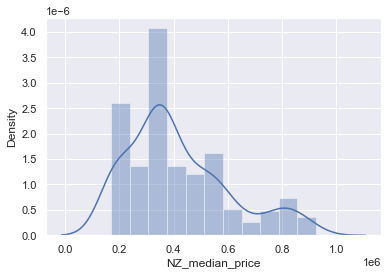

In [496]:
sns.distplot(df_train['NZ_median_price'])
print("Skewness: %f" % df_train['NZ_median_price'].skew())
print("Kurtosis: %f" % df_train['NZ_median_price'].kurt())

In [497]:
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

Number of Numerical features:  19


In [498]:
categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Categorical features:  0


In [499]:
print(df_train[numerical_feats].columns)
print("*"*100)
print(df_train[categorical_feats].columns)

Index(['Date', 'OCR', 'NZ_median_price', 'Auckland_median_price', 'CPI',
       'Inflation', 'Population', 'GDP_Growth_NZ', 'BC_Auckland', 'BC_NZ',
       'Marriage_rate', 'Divorce_rate', 'Birth_rate', 'Earnings',
       'Exchange_rate', 'NZX', 'GDP', 'Election', 'HPI'],
      dtype='object')
****************************************************************************************************
Index([], dtype='object')


In [500]:
df_train[numerical_feats].head()

,Date,OCR,NZ_median_price,Auckland_median_price,CPI,Inflation,Population,GDP_Growth_NZ,BC_Auckland,BC_NZ,Marriage_rate,Divorce_rate,Birth_rate,Earnings,Exchange_rate,NZX,GDP,Election,HPI
0,1,0.0525,170000,230000,687.407882,0.015,3853500,0.054,748,1527,0.1549,0.122,0.0198,542.41,0.513300,1830.84,37596,0,764
1,2,0.0525,171000,245000,687.407882,0.015,3853500,0.054,582,1620,0.1549,0.122,0.0198,542.41,0.491060,1830.84,37596,0,771
2,3,0.0575,175000,240000,687.407882,0.015,3853500,0.054,793,2062,0.1549,0.122,0.0198,542.41,0.491348,1830.84,37596,0,768
3,4,0.0600,177000,245000,692.157986,0.020,3856800,0.060,526,1405,0.1549,0.122,0.0198,540.12,0.496174,1830.84,37020,0,769
4,5,0.0650,172000,240000,692.157986,0.020,3856800,0.060,873,2103,0.1549,0.122,0.0198,540.12,0.471168,1830.84,37020,0,764


In [501]:
df_train[categorical_feats].head()

""
0
1
2
3
4


In [502]:
#List of featuers with missing values
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Date,0,0.0
Marriage_rate,0,0.0
Election,0,0.0
GDP,0,0.0
NZX,0,0.0
Exchange_rate,0,0.0
Earnings,0,0.0
Birth_rate,0,0.0
Divorce_rate,0,0.0
BC_NZ,0,0.0


In [503]:
#Log transformation
for col in numerical_feats:
    try:
        print('{:15}'.format(col), 
            'Skewness: {:05.2f}'.format(df_train[col].skew()) , 
            '   ' ,
            'Kurtosis: {:06.2f}'.format(df_train[col].kurt())  
            )
    except: 
        print('N/A')

Date            Skewness: 00.00     Kurtosis: -01.20
OCR             Skewness: 00.36     Kurtosis: -01.09
NZ_median_price Skewness: 00.86     Kurtosis: 000.09
Auckland_median_price Skewness: 00.61     Kurtosis: -00.71
CPI             Skewness: 00.07     Kurtosis: -00.74
Inflation       Skewness: 01.32     Kurtosis: 001.61
Population      Skewness: 00.31     Kurtosis: -01.08
GDP_Growth_NZ   Skewness: -0.86     Kurtosis: 000.63
BC_Auckland     Skewness: 00.97     Kurtosis: 000.45
BC_NZ           Skewness: 00.82     Kurtosis: 000.40
Marriage_rate   Skewness: -0.46     Kurtosis: -00.86
Divorce_rate    Skewness: -0.09     Kurtosis: -01.13
Birth_rate      Skewness: -0.37     Kurtosis: -00.87
Earnings        Skewness: 00.29     Kurtosis: -00.83
Exchange_rate   Skewness: -0.74     Kurtosis: 000.12
NZX             Skewness: 00.93     Kurtosis: -00.50
GDP             Skewness: 00.34     Kurtosis: -00.79
Election        Skewness: 01.16     Kurtosis: -00.67
HPI             Skewness: 00.82     Kurt

In [504]:
#relationship of features to target
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

Number of Numerical features:  19


In [505]:
numerical_feats

Index(['Date', 'OCR', 'NZ_median_price', 'Auckland_median_price', 'CPI',
       'Inflation', 'Population', 'GDP_Growth_NZ', 'BC_Auckland', 'BC_NZ',
       'Marriage_rate', 'Divorce_rate', 'Birth_rate', 'Earnings',
       'Exchange_rate', 'NZX', 'GDP', 'Election', 'HPI'],
      dtype='object')

In [509]:
li_num_feats = list(numerical_feats)
li_not_plot = ['NZ_median_price']


li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]


c:\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\Python\Python37\lib\site-packages\seabor

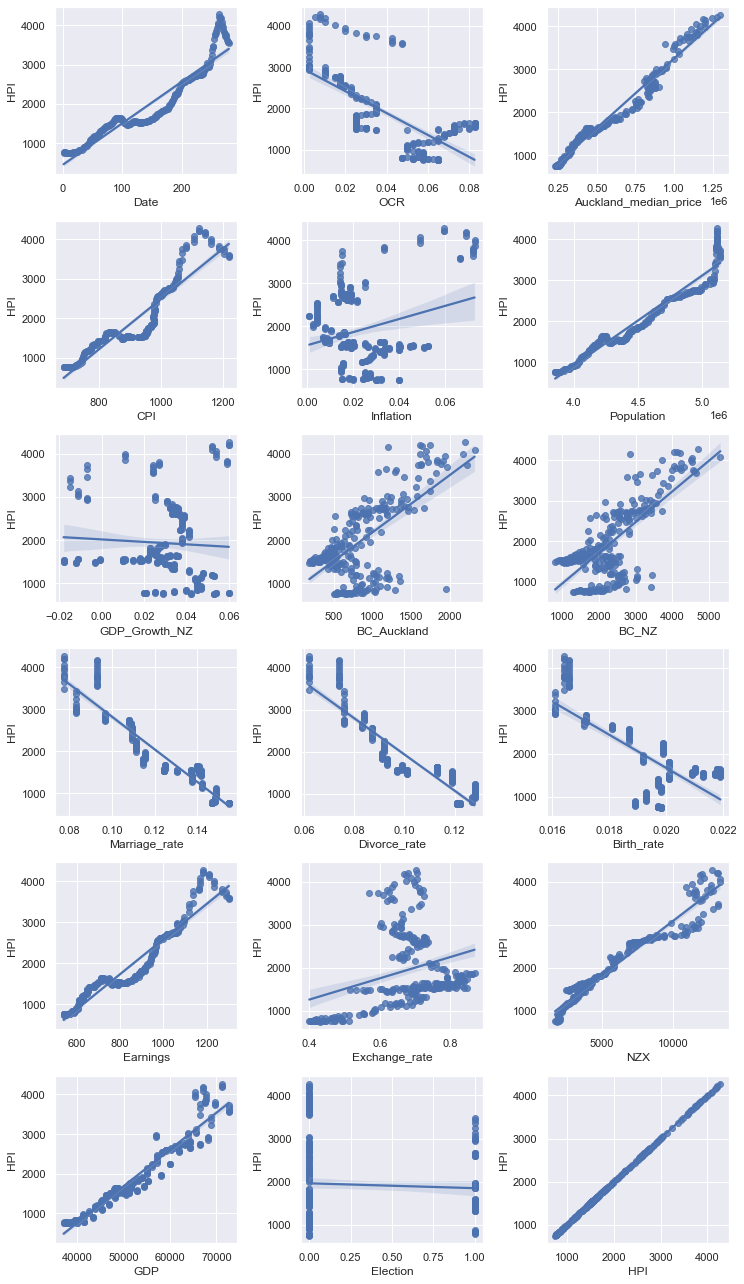

In [510]:
nr_rows = 6
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))
# tips = sns.load_dataset('tips')

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(df_train[li_plot_num_feats[i]], df_train[target], ax = axs[r][c])

            
plt.tight_layout()    
plt.show()   

In [512]:
#Find columns with strong correlation to target
corr = df_train.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

In [513]:
#List of numerical features and their correlation coefficient to target
print(ser_corr)
print("*"*30)
print("List of numerical features with r above min_val_corr :")
print(cols_abv_corr_limit)
print("*"*30)
print("List of numerical features with r below min_val_corr :")
print(cols_bel_corr_limit)

HPI                      1.000000
NZ_median_price          0.995114
Auckland_median_price    0.987165
NZX                      0.971956
Population               0.968605
GDP                      0.961251
Earnings                 0.959048
Date                     0.943244
Marriage_rate            0.943167
CPI                      0.927981
Divorce_rate             0.919398
Birth_rate               0.740551
BC_NZ                    0.737588
OCR                      0.685540
BC_Auckland              0.676555
Exchange_rate            0.304822
Inflation                0.271716
GDP_Growth_NZ            0.056078
Election                 0.054409
Name: HPI, dtype: float64
******************************
List of numerical features with r above min_val_corr :
['HPI', 'NZ_median_price', 'Auckland_median_price', 'NZX', 'Population', 'GDP', 'Earnings', 'Date', 'Marriage_rate', 'CPI', 'Divorce_rate', 'Birth_rate', 'BC_NZ', 'OCR', 'BC_Auckland', 'Exchange_rate']
******************************
List of n

In [514]:
# df_train

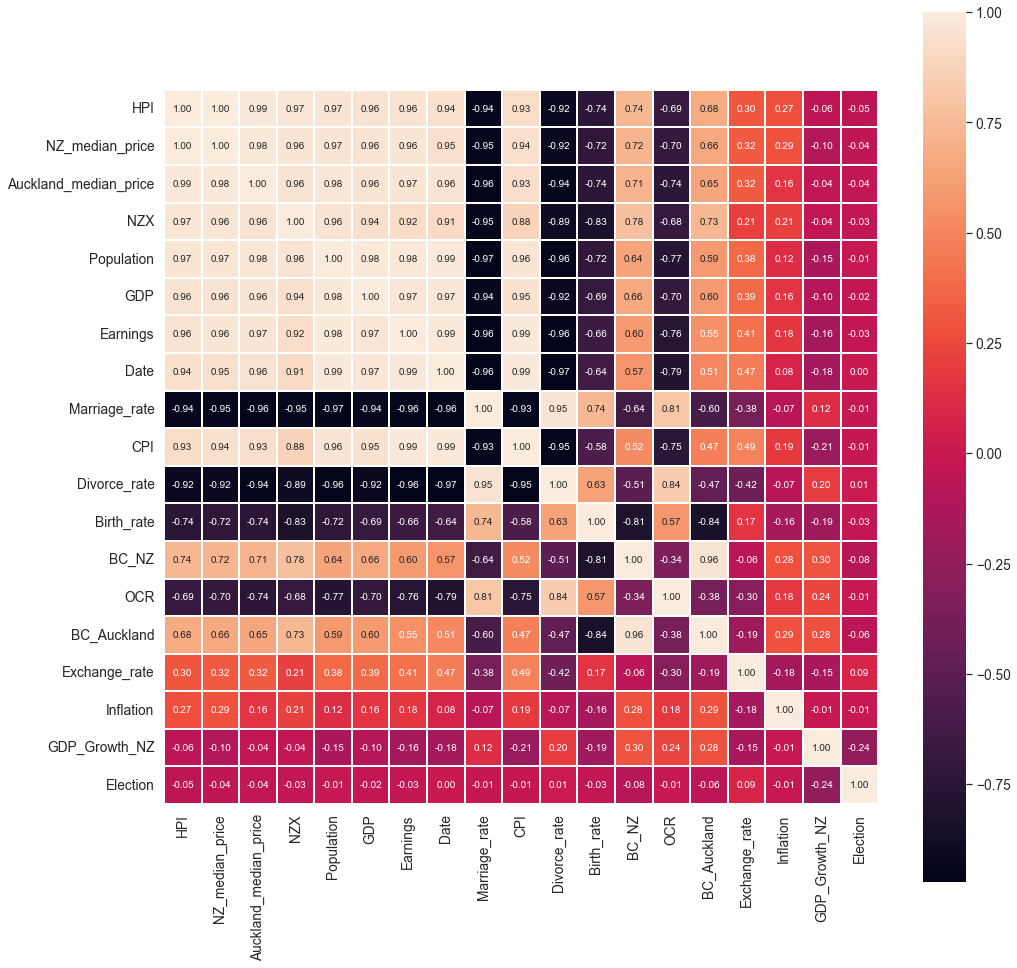

In [515]:
plot_corr_matrix(df_train,24,target)

c:\Python\Python37\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


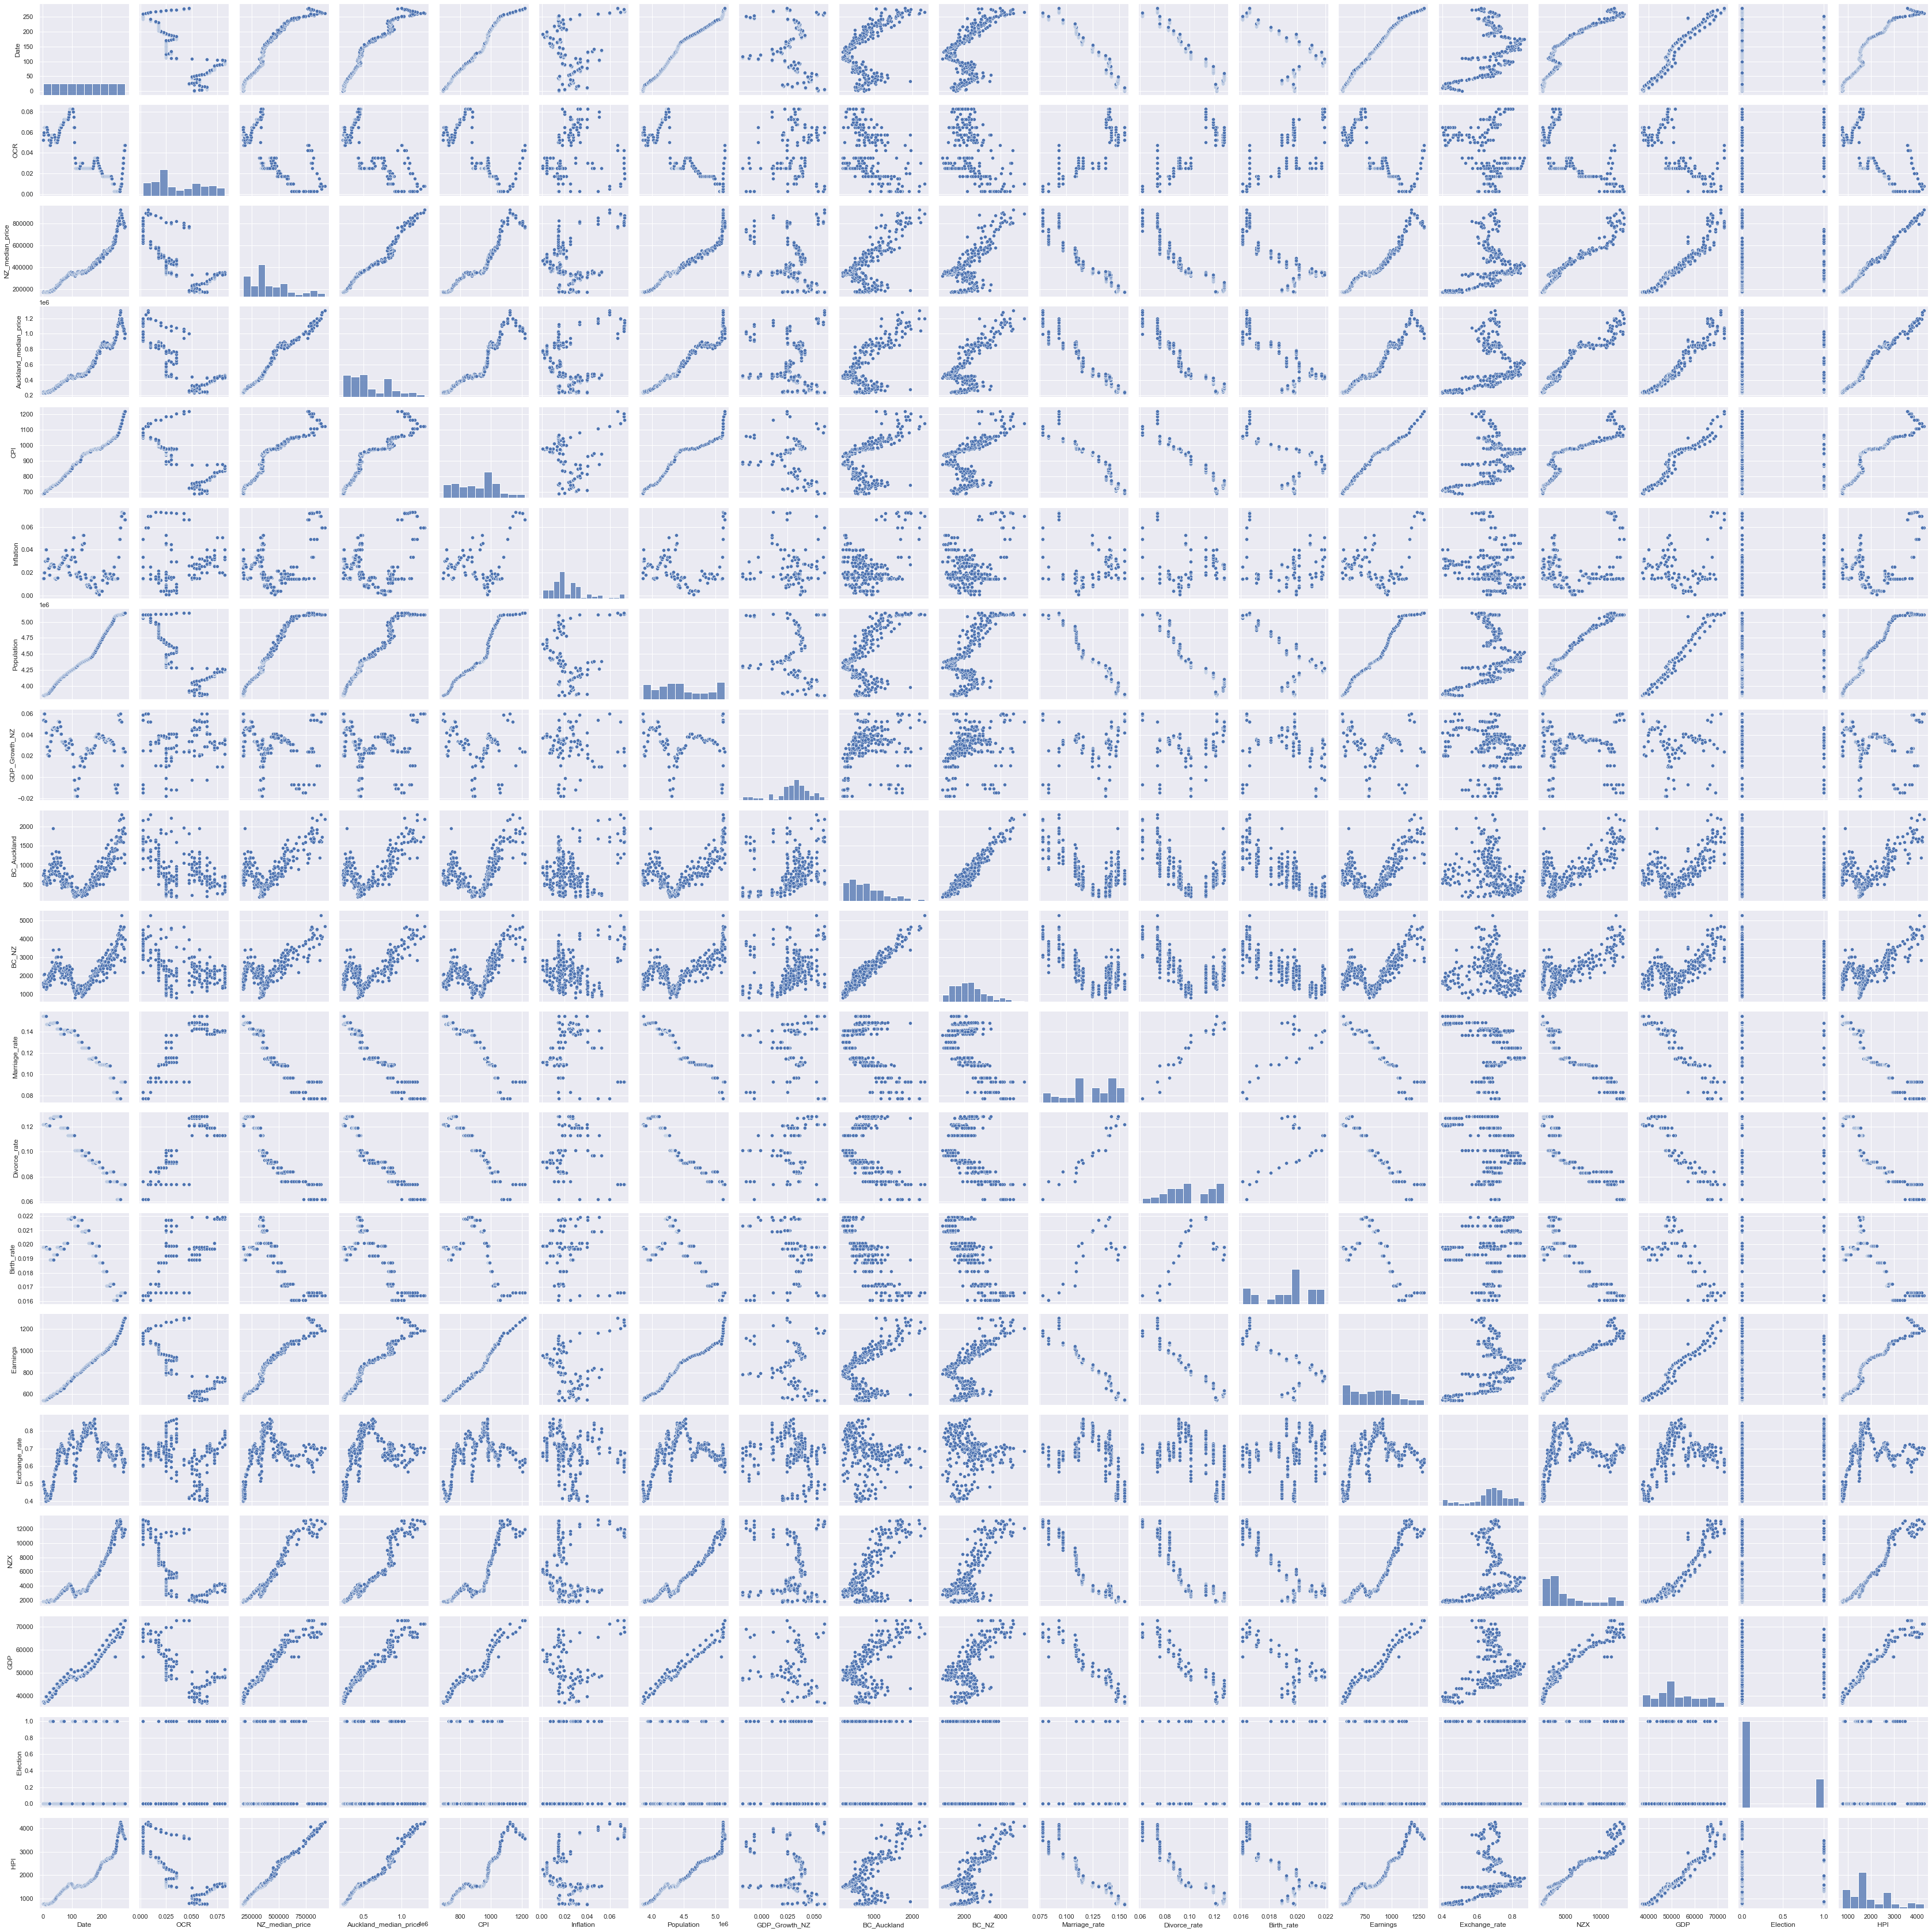

In [516]:
sns.set()
cols = df_train.columns
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

Train a linear regression model

In [517]:
df_train.columns

Index(['Date', 'OCR', 'NZ_median_price', 'Auckland_median_price', 'CPI',
       'Inflation', 'Population', 'GDP_Growth_NZ', 'BC_Auckland', 'BC_NZ',
       'Marriage_rate', 'Divorce_rate', 'Birth_rate', 'Earnings',
       'Exchange_rate', 'NZX', 'GDP', 'Election', 'HPI'],
      dtype='object')

In [639]:
X = df_train[['Date',  'OCR', 'CPI', 'Population', 'BC_NZ', 'Marriage_rate',
       'Divorce_rate', 'Birth_rate', 'Earnings', 'NZX',
       'GDP','Election']]

y = df_train['NZ_median_price']

In [640]:
#Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [641]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [642]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [643]:
pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [644]:
#Linear regression
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)

c:\Python\Python37\lib\site-packages\sklearn\linear_model\_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


LinearRegression(normalize=True)

In [645]:
#Model evaluation
# print the intercept
print(lin_reg.intercept_)

413594.6205128203


In [646]:
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient-Linear'])
coeff_df

,Coefficient-Linear
Date,-195495.375627
OCR,-3599.810088
CPI,75827.531693
Population,85181.570366
BC_NZ,25991.158935
Marriage_rate,-2052.892206
Divorce_rate,-26158.398866
Birth_rate,33952.333574
Earnings,113494.155581
NZX,89885.185924


In [647]:
# coeff_df.to_csv('coefficient.csv')

In [648]:
df_coeff = pd.DataFrame()

In [649]:
df_coeff = coeff_df

In [650]:
pred = lin_reg.predict(X_test)

In [651]:
import hvplot.pandas

In [652]:
pd.DataFrame({'True Values': y_test, 'Predicted Values': pred}).hvplot.scatter(x='True Values', y='Predicted Values')

:Scatter   [True Values]   (Predicted Values)

In [653]:
pd.DataFrame({'Error Values': (y_test - pred)}).hvplot.kde()

:Distribution   [Error Values]   (Density)

In [654]:
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])

Test set evaluation:
_____________________________________
MAE: 21070.82292572444
MSE: 896131924.9531426
RMSE: 29935.462664758375
R2 Square 0.9774903391383238
__________________________________
Train set evaluation:
_____________________________________
MAE: 16000.65465648082
MSE: 522812133.0930741
RMSE: 22865.085459999358
R2 Square 0.9843602705077208
__________________________________


In [655]:
#Ridge
from sklearn.linear_model import Ridge

model = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_pred) , cross_val(Ridge())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 31626.447956504024
MSE: 2099223474.5565312
RMSE: 45817.28357897848
R2 Square 0.9472702543349207
__________________________________
Train set evaluation:
_____________________________________
MAE: 27005.62507787667
MSE: 1368065150.9189231
RMSE: 36987.36474688246
R2 Square 0.9590748425029819
__________________________________


In [656]:
model.intercept_

413594.6205128205

In [657]:
ridge_coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient-Ridge'])


In [658]:
ridge_coeff_df

,Coefficient-Ridge
Date,17008.209800
OCR,482.123212
CPI,21835.760013
Population,19205.242348
BC_NZ,18420.807562
Marriage_rate,-15440.391323
Divorce_rate,-16771.554899
Birth_rate,-7109.130338
Earnings,21975.705695
NZX,23268.939622


In [659]:
df_coeff = df_coeff.join(ridge_coeff_df,how='left')

In [660]:
df_coeff

,Coefficient-Linear,Coefficient-Ridge
Date,-195495.375627,17008.209800
OCR,-3599.810088,482.123212
CPI,75827.531693,21835.760013
Population,85181.570366,19205.242348
BC_NZ,25991.158935,18420.807562
Marriage_rate,-2052.892206,-15440.391323
Divorce_rate,-26158.398866,-16771.554899
Birth_rate,33952.333574,-7109.130338
Earnings,113494.155581,21975.705695
NZX,89885.185924,23268.939622


In [661]:
#Lasso regression
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.1, 
              precompute=True, 
#               warm_start=True, 
              positive=True, 
              selection='random',
              random_state=42)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Lasso Regression", *evaluate(y_test, test_pred) , cross_val(Lasso())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 22523.492119132417
MSE: 1347583165.9512155
RMSE: 36709.44246309409
R2 Square 0.9661504749425684
__________________________________
Train set evaluation:
_____________________________________
MAE: 17493.569809248595
MSE: 707847682.2441982
RMSE: 26605.40701143657
R2 Square 0.9788250012360268
__________________________________


c:\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67726846140.180275, tolerance: 651855046.4921918
  positive,
c:\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.452e+10, tolerance: 8.057e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
c:\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.668e+10, tolerance: 8.576e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positi

In [662]:
model.intercept_

413594.62051282043

In [663]:
Lasso_coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient-Lasso'])


In [664]:
Lasso_coeff_df

,Coefficient-Lasso
Date,0.000000
OCR,0.000000
CPI,32253.365251
Population,0.000000
BC_NZ,18717.786956
Marriage_rate,26519.148325
Divorce_rate,0.000000
Birth_rate,22381.823240
Earnings,72183.896011
NZX,110761.316917


In [665]:
df_coeff = df_coeff.join(Lasso_coeff_df,how='left')

In [666]:
#Elastic net
from sklearn.linear_model import ElasticNet

model = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Elastic Net Regression", *evaluate(y_test, test_pred) , cross_val(ElasticNet())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 21475.252421545407
MSE: 1067260557.200342
RMSE: 32668.954026726078
R2 Square 0.973191811914435
__________________________________
Train set evaluation:
_____________________________________
MAE: 17067.873153575667
MSE: 644947842.082073
RMSE: 25395.823319634135
R2 Square 0.9807066264374604
__________________________________


c:\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.170e+11, tolerance: 8.057e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
c:\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.128e+11, tolerance: 8.576e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
c:\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. 

In [667]:
model.intercept_

413594.62051282043

In [668]:
EN_coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient-EN'])

In [669]:
EN_coeff_df

,Coefficient-EN
Date,-41341.609425
OCR,4119.045118
CPI,53148.617321
Population,14431.733681
BC_NZ,25327.410901
Marriage_rate,6696.602868
Divorce_rate,-22686.794142
Birth_rate,19673.761616
Earnings,60226.938909
NZX,88726.684480


In [670]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=2)

X_train_2_d = poly_reg.fit_transform(X_train)
X_test_2_d = poly_reg.transform(X_test)

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train_2_d,y_train)

test_pred = lin_reg.predict(X_test_2_d)
train_pred = lin_reg.predict(X_train_2_d)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Polynomail Regression", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 14944.380952380952
MSE: 405740630.0952381
RMSE: 20143.004495239486
R2 Square 0.9898083265120544
__________________________________
Train set evaluation:
_____________________________________
MAE: 6297.892307692307
MSE: 58883986.24102564
RMSE: 7673.590179376642
R2 Square 0.998238507567167
__________________________________


c:\Python\Python37\lib\site-packages\sklearn\linear_model\_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


In [671]:
df_coeff = df_coeff.join(EN_coeff_df,how='left')

In [672]:
#Stochastic Gradient Descent
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(n_iter_no_change=250, penalty=None, eta0=0.0001, max_iter=100000)
sgd_reg.fit(X_train, y_train)

test_pred = sgd_reg.predict(X_test)
train_pred = sgd_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Stochastic Gradient Descent", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 21857.55659623335
MSE: 1129775761.4320695
RMSE: 33612.13711491832
R2 Square 0.9716215118204748
__________________________________
Train set evaluation:
_____________________________________
MAE: 18177.791003463364
MSE: 724018621.6635313
RMSE: 26907.594126259806
R2 Square 0.9783412536292945
__________________________________


c:\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


In [673]:
sgd_reg.intercept_

array([413594.68167032])

In [674]:
sgd_coeff_df = pd.DataFrame(sgd_reg.coef_, X.columns, columns=['Coefficient-SGD'])

In [675]:
sgd_coeff_df

,Coefficient-SGD
Date,-17860.695429
OCR,9500.538107
CPI,44522.653888
Population,15703.709850
BC_NZ,26322.540522
Marriage_rate,1943.936416
Divorce_rate,-25921.412964
Birth_rate,16052.584815
Earnings,48238.732367
NZX,75043.862767


In [676]:
df_coeff = df_coeff.join(sgd_coeff_df,how='left')

In [677]:
pd.DataFrame({'True Values': y_test, 'Predicted Values': pred}).hvplot.scatter(x='True Values', y='Predicted Values')

:Scatter   [True Values]   (Predicted Values)

In [678]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=1000)
rf_reg.fit(X_train, y_train)

test_pred = rf_reg.predict(X_test)
train_pred = rf_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 12120.619142857144
MSE: 465522548.57562155
RMSE: 21575.971555775224
R2 Square 0.9883066829781247
__________________________________
Train set evaluation:
_____________________________________
MAE: 2990.0176717948707
MSE: 22207826.91851134
RMSE: 4712.518108030073
R2 Square 0.9993356611608035
__________________________________


In [679]:
rf_importance_features = pd.DataFrame(rf_reg.feature_importances_, X.columns, columns=['Coefficient'])

In [680]:
rf_importance_features

,Coefficient
Date,0.207190
OCR,0.001092
CPI,0.202460
Population,0.158678
BC_NZ,0.001501
Marriage_rate,0.063416
Divorce_rate,0.056514
Birth_rate,0.057662
Earnings,0.122795
NZX,0.109034


In [681]:
#Polynomial regression
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=2)

X_train_2_d = poly_reg.fit_transform(X_train)
X_test_2_d = poly_reg.transform(X_test)

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train_2_d,y_train)

test_pred = lin_reg.predict(X_test_2_d)
train_pred = lin_reg.predict(X_train_2_d)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Polynomial Regression", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 14944.380952380952
MSE: 405740630.0952381
RMSE: 20143.004495239486
R2 Square 0.9898083265120544
__________________________________
Train set evaluation:
_____________________________________
MAE: 6297.892307692307
MSE: 58883986.24102564
RMSE: 7673.590179376642
R2 Square 0.998238507567167
__________________________________


c:\Python\Python37\lib\site-packages\sklearn\linear_model\_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


In [697]:
lin_reg.intercept_

-1.0047619547781176e+18

In [696]:
lin_reg.coef_

array([ 1.00476195e+18,  4.83917818e+04, -8.80175846e+03,  7.78016512e+04,
        1.50643562e+05,  7.04150038e+03,  1.82748916e+04,  5.25484774e+03,
       -1.43080722e+04, -8.63320925e+04,  8.87887050e+03, -1.10077132e+04,
        2.95589817e+03,  1.95037396e+05, -1.18781371e+05, -5.38870361e+05,
       -9.20707106e+05, -1.10519609e+05, -2.34468349e+05,  5.18882655e+05,
        5.81766571e+03,  1.26344878e+06,  3.39019937e+05, -1.65037794e+05,
        5.38822135e+04,  1.28448909e+04, -1.93391640e+05,  4.78400735e+05,
        3.28494817e+02,  4.57326393e+04, -7.15860015e+04,  1.22906659e+04,
       -5.05997863e+04, -7.08428173e+04, -5.24965625e+04,  4.70884529e+02,
        5.64689411e+05,  2.59909754e+05,  6.95330533e+04,  6.70495482e+05,
       -1.98649671e+04, -1.70099486e+05, -9.68484524e+05,  1.53833337e+05,
        4.86914529e+05, -5.71930124e+04,  8.16446150e+04,  7.73315094e+04,
       -5.46061504e+04, -5.61762456e+05,  1.06649079e+05,  6.68033343e+05,
       -3.70753424e+05, -

In [698]:
poly_reg.powers_

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 2, 0],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 2]], dtype=int64)

In [ ]:
poly_reg

In [682]:
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,21070.822926,8.961319e+08,29935.462665,0.977490,-6.597512
1,Ridge Regression,31626.447957,2.099223e+09,45817.283579,0.947270,-5.298600
2,Lasso Regression,22523.492119,1.347583e+09,36709.442463,0.966150,-6.217785
3,Elastic Net Regression,21475.252422,1.067261e+09,32668.954027,0.973192,-5.241867
4,Polynomail Regression,14944.380952,4.057406e+08,20143.004495,0.989808,0.000000
5,Stochastic Gradient Descent,21857.556596,1.129776e+09,33612.137115,0.971622,0.000000
6,Random Forest Regressor,12120.619143,4.655225e+08,21575.971556,0.988307,0.000000
7,Polynomial Regression,14944.380952,4.057406e+08,20143.004495,0.989808,0.000000


In [683]:
results_df.columns

Index(['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'], dtype='object')

In [684]:
# results_df = results_df.loc[results_df['Model'] != 'Polynomail Regression']

In [685]:
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,21070.822926,8.961319e+08,29935.462665,0.977490,-6.597512
1,Ridge Regression,31626.447957,2.099223e+09,45817.283579,0.947270,-5.298600
2,Lasso Regression,22523.492119,1.347583e+09,36709.442463,0.966150,-6.217785
3,Elastic Net Regression,21475.252422,1.067261e+09,32668.954027,0.973192,-5.241867
4,Polynomail Regression,14944.380952,4.057406e+08,20143.004495,0.989808,0.000000
5,Stochastic Gradient Descent,21857.556596,1.129776e+09,33612.137115,0.971622,0.000000
6,Random Forest Regressor,12120.619143,4.655225e+08,21575.971556,0.988307,0.000000
7,Polynomial Regression,14944.380952,4.057406e+08,20143.004495,0.989808,0.000000


<AxesSubplot:ylabel='Model'>

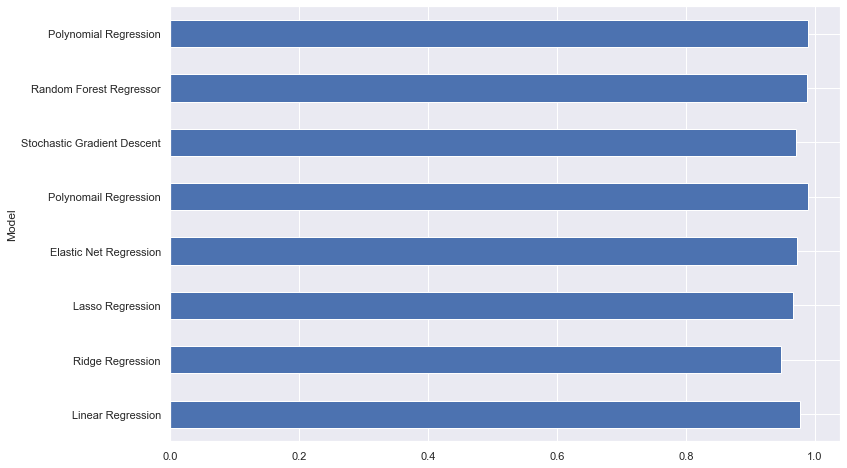

In [686]:
results_df.set_index('Model', inplace=True)
results_df['R2 Square'].plot(kind='barh', figsize=(12, 8))

<AxesSubplot:ylabel='Model'>

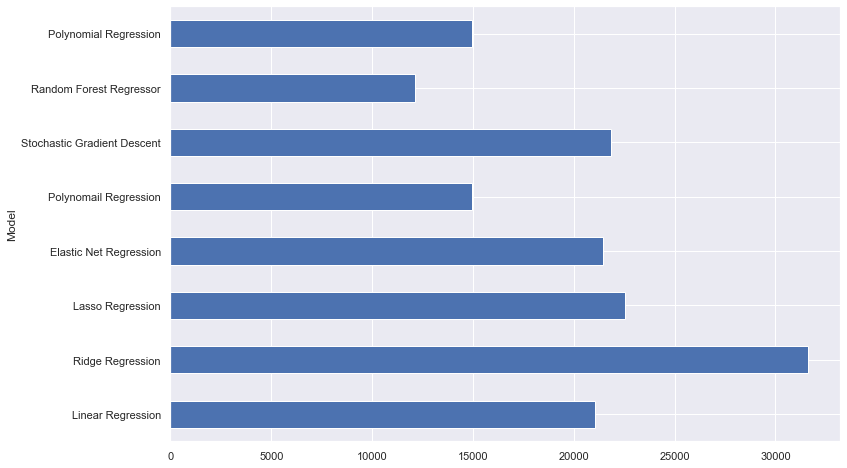

In [687]:
results_df['MAE'].plot(kind='barh', figsize=(12, 8))

<AxesSubplot:ylabel='Model'>

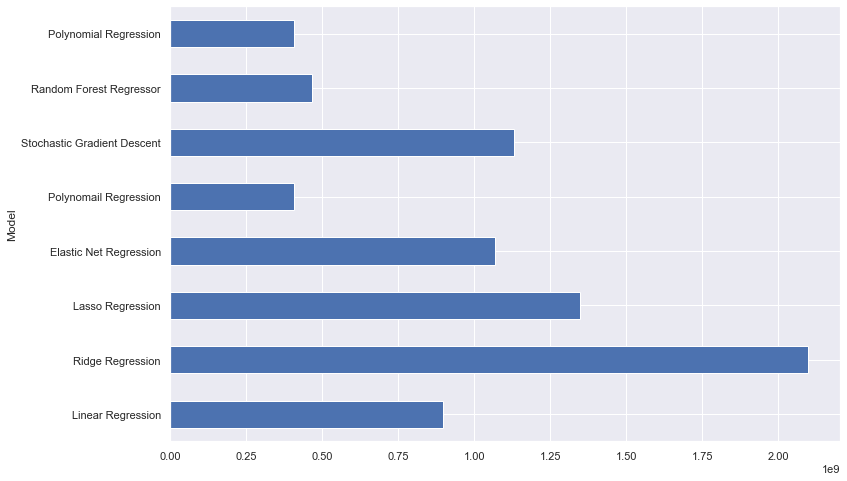

In [688]:
results_df['MSE'].plot(kind='barh', figsize=(12, 8))

<AxesSubplot:ylabel='Model'>

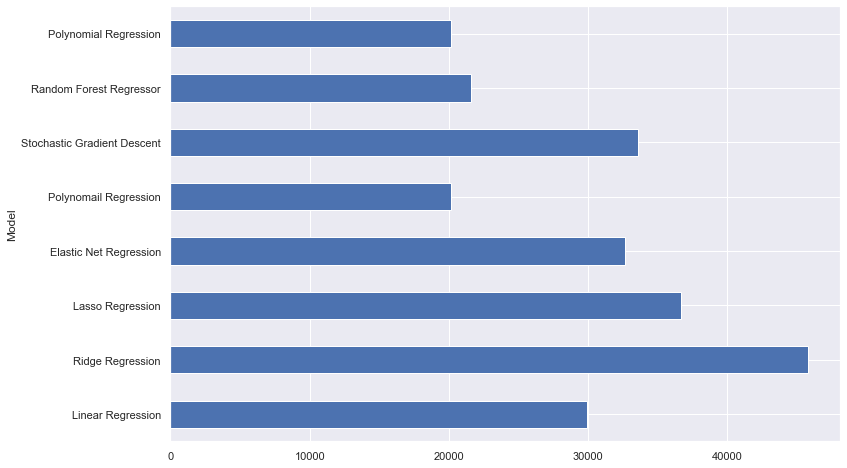

In [689]:
results_df['RMSE'].plot(kind='barh', figsize=(12, 8))

In [690]:
df_coeff

,Coefficient-Linear,Coefficient-Ridge,Coefficient-Lasso,Coefficient-EN,Coefficient-SGD
Date,-195495.375627,17008.209800,0.000000,-41341.609425,-17860.695429
OCR,-3599.810088,482.123212,0.000000,4119.045118,9500.538107
CPI,75827.531693,21835.760013,32253.365251,53148.617321,44522.653888
Population,85181.570366,19205.242348,0.000000,14431.733681,15703.709850
BC_NZ,25991.158935,18420.807562,18717.786956,25327.410901,26322.540522
Marriage_rate,-2052.892206,-15440.391323,26519.148325,6696.602868,1943.936416
Divorce_rate,-26158.398866,-16771.554899,0.000000,-22686.794142,-25921.412964
Birth_rate,33952.333574,-7109.130338,22381.823240,19673.761616,16052.584815
Earnings,113494.155581,21975.705695,72183.896011,60226.938909,48238.732367
NZX,89885.185924,23268.939622,110761.316917,88726.684480,75043.862767


In [691]:
df_coeff.to_csv('Coefficient_table.csv')